In [1]:
# Load data ke dalam data frame 
import pandas as pd

# spesifikasi encoding diperlukan karena data tidak menggunakan UTF-8
df = pd.read_csv('allreview_clean.csv', encoding='latin-1') 

df.head()

,review_tokens_stemmed,sentimen,classified_text,tweet_text,sentence_score,max_positive,max_negative,kelas
0,kulit kerut,"{'classified_text': 'kulit kerut [-2]', 'tweet...",kulit kerut [-2],kulit kerut,['kulit kerut [-2]'],1,-2,negatif
1,tipe kulit kering,"{'classified_text': 'tipe kulit kering', 'twee...",tipe kulit kering,tipe kulit kering,['tipe kulit kering'],1,-1,netral
2,bagus banget lip tint nya warna bagus kemas ge...,{'classified_text': 'bagus [5] banget lip tint...,bagus [5] banget lip tint nya warna bagus [4] ...,bagus banget lip tint nya warna bagus kemas g...,['bagus [5] banget lip tint nya warna bagus [4...,5,-1,positif
3,expire kirim cepat cocok guna sesuai instruksi,{'classified_text': 'expire kirim cepat [4] co...,expire kirim cepat [4] cocok [4] guna sesuai [...,expire kirim cepat cocok guna sesuai instruksi,['expire kirim cepat [4] cocok [4] guna sesuai...,4,-1,positif
4,no review found,"{'classified_text': 'no review found', 'tweet_...",no review found,no review found,['no review found'],1,-1,netral


In [2]:
# Drop 3 kolom terakhir yang tidak digunakan dengan fungsi iloc
df = df.drop(df.iloc[:,1:7], axis=1)

# Cek data teratas
df.head()

,review_tokens_stemmed,kelas
0,kulit kerut,negatif
1,tipe kulit kering,netral
2,bagus banget lip tint nya warna bagus kemas ge...,positif
3,expire kirim cepat cocok guna sesuai instruksi,positif
4,no review found,netral


In [3]:
# Data untuk rename kolom v1 dan v2
new_cols = {
    'review_tokens_stemmed' : 'Review',
    'kelas' : 'Sentiment'
}

# Rename nama kolom v1 dan v2
df = df.rename(columns=new_cols)

# Cek data teratas
df.head()

,Review,Sentiment
0,kulit kerut,negatif
1,tipe kulit kering,netral
2,bagus banget lip tint nya warna bagus kemas ge...,positif
3,expire kirim cepat cocok guna sesuai instruksi,positif
4,no review found,netral


In [4]:
# Cek jumlah data per kelas
print(df['Sentiment'].value_counts())
print('\n')

# Cek kelengkapan data
print(df.info())
print('\n')

# Cek statistik deskriptif
print(df.describe())

positif    1129
netral      358
negatif     133
Name: Sentiment, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     1620 non-null   object
 1   Sentiment  1620 non-null   object
dtypes: object(2)
memory usage: 25.4+ KB
None


                 Review Sentiment
count              1620      1620
unique             1499         3
top     coba moga cocok   positif
freq                 16      1129


In [5]:
# Data untuk label
new_labels = {
    'negatif' : 0,
    'netral' : 1,
    'positif' : 2
}

# Encode label (mengubah label dari spam dan ham menjadi 1 dan 0)
df['Sentiment'] = df['Sentiment'].map(new_labels)

# Cek data teratas
df.head()

,Review,Sentiment
0,kulit kerut,0
1,tipe kulit kering,1
2,bagus banget lip tint nya warna bagus kemas ge...,2
3,expire kirim cepat cocok guna sesuai instruksi,2
4,no review found,1


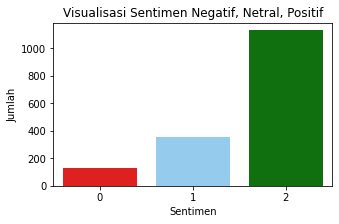

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualisasi sentimen positif, netral, dan negatif
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Sentiment', palette={0: 'red', 1: 'lightskyblue', 2: 'green'})
plt.title('Visualisasi Sentimen Negatif, Netral, Positif')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [7]:
# Memisahkan fitur dengan label
X = df['Review'].values
y = df['Sentiment'].values

In [8]:
# Ekstraksi fitur
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Inisialisasi model
mnb = MultinomialNB()

# Membuat objek StratifiedKFold untuk 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Inisialisasi TfidfVectorizer
bow = TfidfVectorizer(max_features=510)

# List untuk menyimpan prediksi dan label sebenarnya dari setiap lipatan
all_predictions = []
all_true_labels = []

# Loop melalui setiap lipatan (fold) dalam cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]  # Data latih dan uji
    y_train, y_test = y[train_index], y[test_index]  # Label data latih dan uji

    # Transformasi seluruh data menggunakan TfidfVectorizer
    X_train_transform = bow.fit_transform(X_train)
    X_test_transform = bow.transform(X_test)

    # Melatih model klasifikasi pada data latih
    mnb.fit(X_train_transform, y_train)

    # Membuat prediksi pada data uji
    predictions = mnb.predict(X_test_transform)

    # Menambahkan prediksi dan label sebenarnya ke dalam list
    all_predictions.extend(predictions)
    all_true_labels.extend(y_test)

In [9]:
# Hitung metrik evaluasi
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='weighted')
recall = recall_score(all_true_labels, all_predictions, average='weighted')
f1 = f1_score(all_true_labels, all_predictions, average='weighted')

# Print hasil
print("Overall accuracy:", accuracy)
print("Overall precision:", precision)
print("Overall recall:", recall)
print("Overall F1-score:", f1)

print(f'Confusion Matrix : \n {confusion_matrix(all_true_labels, all_predictions)}')
print('-----------------------------------------------------\n')
print(classification_report(all_true_labels, all_predictions, zero_division=0))

Overall accuracy: 0.7765432098765432
Overall precision: 0.7883126365676906
Overall recall: 0.7765432098765432
Overall F1-score: 0.7280934223362148
Confusion Matrix : 
 [[  58   17   58]
 [   0   77  281]
 [   2    4 1123]]
-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.97      0.44      0.60       133
           1       0.79      0.22      0.34       358
           2       0.77      0.99      0.87      1129

    accuracy                           0.78      1620
   macro avg       0.84      0.55      0.60      1620
weighted avg       0.79      0.78      0.73      1620



In [13]:
new_text = input("\nMasukkan teks baru: ")
new_text_vec = bow.transform([new_text])
predicted_sentimen = mnb.predict(new_text_vec)

if predicted_sentimen[0] == 0:
    sentiment_label = "negatif"
elif predicted_sentimen[0] == 1:
    sentiment_label = "netral"
elif predicted_sentimen[0] == 2:
    sentiment_label = "positif"

print("Hasil Analisis Sentimen untuk Teks Baru : ", sentiment_label)

Hasil Analisis Sentimen untuk Teks Baru :  positif
